In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import datasets, transforms
import os
import numpy as np
from PIL import Image
import PIL
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import random
import segmentation_models_pytorch as smp

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

batch_size = 16

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),])
transform2 = transforms.Compose([transforms.ToTensor(),])
transform_label = transforms.Compose([transforms.ToTensor(),])

transformToPIL = T.ToPILImage()

Using cuda device


In [6]:
class UlcerData(Dataset):
    def __init__(self, imagePath, maskPath, transforms, transform2):
        self.imagePath = imagePath
        self.maskPath = maskPath
        self.transforms = transforms
        self.transform2 = transform2
        self.all_images = os.listdir(imagePath)
        self.all_labels = os.listdir(maskPath)
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.imagePath, self.all_images[idx])
        label_loc = os.path.join(self.maskPath, self.all_labels[idx])
        image = Image.open(img_loc)
        label = Image.open(label_loc).convert('L')
        return (self.transforms(image),self.transform2(label))

In [7]:
class UlcerDataRotate(Dataset):
    def __init__(self, imagePath, maskPath, transforms, transform2):
        self.imagePath = imagePath
        self.maskPath = maskPath
        self.transforms = transforms
        self.transform2 = transform2
        self.all_images = os.listdir(imagePath)
        self.all_labels = os.listdir(maskPath)
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.imagePath, self.all_images[idx])
        label_loc = os.path.join(self.maskPath, self.all_labels[idx])
        rotationParameter = T.RandomRotation.get_params((0,180))
        image = Image.open(img_loc)
        label = Image.open(label_loc).convert('L')
        image = self.transforms(image)
        label = self.transform2(label)
        image = T.functional.rotate(image,rotationParameter)
        label = T.functional.rotate(label,rotationParameter)
        return (image, label)

In [8]:
class UlcerDataFlip(Dataset):
    def __init__(self, imagePath, maskPath, transforms, transform2):
        self.imagePath = imagePath
        self.maskPath = maskPath
        self.transforms = transforms
        self.transform2 = transform2
        self.all_images = os.listdir(imagePath)
        self.all_labels = os.listdir(maskPath)
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.imagePath, self.all_images[idx])
        label_loc = os.path.join(self.maskPath, self.all_labels[idx])
        image = Image.open(img_loc)
        label = Image.open(label_loc).convert('L')
        horizontal = T.RandomHorizontalFlip(p=1)
        vertical = T.RandomVerticalFlip(p=1)
        image = self.transforms(image)
        label = self.transform2(label)
        if random.randint(1,2) == 1:
            image = horizontal(image)
            label = horizontal(label)
        else:
            image = vertical(image)
            label = vertical(label)
        return (image, label)

In [9]:
class UlcerDataShear(Dataset):
    def __init__(self, imagePath, maskPath, transforms, transform2):
        self.imagePath = imagePath
        self.maskPath = maskPath
        self.transforms = transforms
        self.transform2 = transform2
        self.all_images = os.listdir(imagePath)
        self.all_labels = os.listdir(maskPath)
        
    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.imagePath, self.all_images[idx])
        label_loc = os.path.join(self.maskPath, self.all_labels[idx])
        shearP = random.randint(-30,30)
        image = Image.open(img_loc)
        label = Image.open(label_loc).convert('L')
        image = self.transforms(image)
        label = self.transform2(label)
        image = T.functional.affine(image, 0, (0, 0), 1, shearP)
        label = T.functional.affine(label, 0, (0, 0), 1, shearP)
        return (image, label)

In [ ]:
#Augmentations

transform_blur = transforms.Compose([transforms.ToTensor(),T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
transform_bright = transforms.Compose([transforms.ToTensor(),T.ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])



dataset = UlcerData("data/train/images","data/train/labels",transform,transform2)
#dataset_blur = UlcerData("data/train/images","data/train/labels",transform_blur,transform2)
dataset_rotation = UlcerDataRotate("data/train/images","data/train/labels",transform,transform2)
dataset_flip = UlcerDataFlip("data/train/images","data/train/labels",transform,transform2)
dataset_shear = UlcerDataShear("data/train/images","data/train/labels",transform,transform2)
#dataset_bright = UlcerData("data/train/images","data/train/labels",transform_bright,transform2)

valid_dataset = UlcerData("data/validation/images","data/validation/labels",transform,transform2)

a = torch.utils.data.ConcatDataset([dataset,dataset_rotation,dataset_flip,dataset_shear])
print(len(a))

In [ ]:
train_loader = DataLoader(a,batch_size=batch_size,shuffle = True)
valid_loader = DataLoader(valid_dataset,batch_size=1,shuffle = False)
len(train_loader)

In [16]:
encoder = 'resnet34'
encoder_weights = 'imagenet'


model = smp.Unet(
    encoder_name=encoder, 
    encoder_weights=encoder_weights, 
    classes=1,
    in_channels=3,
)          

#model.parameters

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [18]:
lossF = nn.BCEWithLogitsLoss() #smp.losses.DiceLoss("binary")  

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [ ]:
model.to(device)

for epoch in range(80): 
    for i, data in enumerate(train_loader): 

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = lossF(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
          
        print(f"Epoch {epoch} i {i}, Training loss {loss.item():.4f}")

print('Finished Training')
torch.save(model, './model.pth')

In [ ]:
#dice fuer validation ohne leere masken
model.eval()

allTP = 0
allFP = 0
allFN = 0
allTN = 0
maxx = 0
minn = 0
for i, data in enumerate(valid_loader):
        inputs, labels = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            val_prediction = model(inputs)
            tp, fp, fn, tn = smp.metrics.get_stats(val_prediction, labels.long(), mode='binary', threshold=0.5)
        allTP += tp.sum().item()
        allFP += fp.sum().item()
        allFN += fn.sum().item()
        allTN += tn.sum().item()

        au = (2*tp)/(2*tp+fp+fn)

        if i==0 or (minn > au and au > 0.001):
            minn = au
        if maxx < au:
            maxx = au
        
        
print(f" Dice: {(2*allTP)/(2*allTP+allFP+allFN)}")
print(f"min {minn.item()}")
print(f"max {maxx.item()}")
iou = allTP/(allTP+allFP+allFN)
print(iou)

In [ ]:
#dice on dataset

main = DataLoader(dataset,batch_size=batch_size,shuffle = True)
allTP = 0
allFP = 0
allFN = 0
allTN = 0
for i, data in enumerate(main):
        inputs, labels = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            val_prediction = model(inputs)
            tp, fp, fn, tn = smp.metrics.get_stats(val_prediction, labels.long(), mode='binary', threshold=0.5)
        
        allTP += tp.sum().item()
        allFP += fp.sum().item()
        allFN += fn.sum().item()
        allTN += tn.sum().item()
        #print(allTP)
        
        
print(f" Dice: {(2*allTP)/(2*allTP+allFP+allFN)}")
iou2 = allTP/(allTP+allFP+allFN)
print(iou2)

[16, 17, 18, 19, 20]
dice: 0.9762119843420657
Jaccard: 0.9535294117647058

dice: 0.6153477218225419
Jaccard: 0.4444059577416003

dice: 0.9517601043024772
Jaccard: 0.9079601990049752

dice: 0.7391638165701123
Jaccard: 0.5862488928255093

dice: 0.8591789310611929
Jaccard: 0.7531233025529603



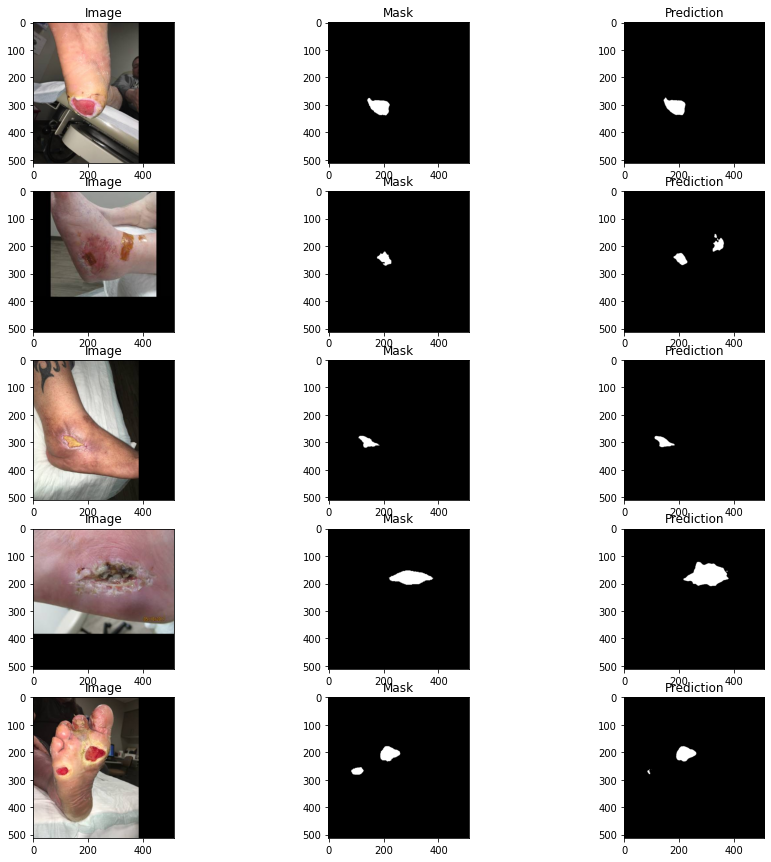

In [23]:
transformToPIL = transforms.ToPILImage()


transformT = T.ToTensor()
anzeige = UlcerData("data/validation/images","data/validation/labels",transformT,transform2)

fig, ax = plt.subplots(nrows=5, ncols=3,figsize=(15, 15))
for i in range(0,5): #Number of example
    a = np.random.randint(1,100)
    image, mask = valid_dataset[a]
    anzeig, _ = anzeige[a]
    anzeig = transformToPIL(anzeig)
    img = transformToPIL(image)
    image = image.unsqueeze(0)
    pre_mask = model(image.to('cuda'))
    tp, fp, fn, tn = smp.metrics.get_stats(pre_mask.to('cpu').squeeze(), mask.long().squeeze(), mode='binary', threshold=0.5)
    tp = tp.sum().item()
    fp = fp.sum().item()
    fn = fn.sum().item()
    tn = tn.sum().item()
    print(f'dice: {(2*tp)/((2*tp)+fn+fp) }')
    print(f'Jaccard: {tp/(tp+fp+fn)}')
    print()
    pre_mask = pre_mask.squeeze()
    pre_mask = (pre_mask>0.5).float()
    pre = transformToPIL(pre_mask)
    ax[i,0].imshow(anzeig)
    mask = transformToPIL(mask)
    ax[i,1].imshow(mask,cmap='gray')
    #print(pre_mask.detach())
    ax[i,2].imshow(pre_mask.cpu().detach(),cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,1].set_title('Mask')
    ax[i,2].set_title('Prediction')
plt.show()